In [ ]:
# add root folder to the path
import sys
sys.path.append('..')

In [2]:
import json
import os
from glob import glob
from time import time

import cv2
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm

from retinanet.dataset_utils.coco_parser import CocoParser
from retinanet.eval import COCOEvaluator
from retinanet.image_utils import imshow, read_image, visualize_detections_cv2

print('TensorFlow: ', tf.__version__)

TensorFlow:  2.8.0-dev20211011


In [3]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print('Found {} GPU(s)'.format(len(gpus)))
    [tf.config.experimental.set_memory_growth(device, True) for device in gpus]
    
    # Setup a virtual GPUs to emulate multi GPU setup
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[
            tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000),
            tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])
    try:
        # Attempt to load tensorrt, only used if the saved_model contains
        # TensorRT engines.
        import tensorrt as trt
        trt.init_libnvinfer_plugins(None, '')
        # Starting from tensorflow==2.5.0, TensorRT ignores the conversion
        # of combined_nms op if number of anchors is more than 4096.
        # Setting`TF_TRT_ALLOW_NMS_TOPK_OVERRIDE=1` will allow TensorRT to run
        # top_k filtering with k=4096 prior to running NMS.
        # refer https://github.com/tensorflow/tensorflow/issues/46453
        # and https://github.com/tensorflow/tensorflow/pull/47698
        os.environ['TF_TRT_ALLOW_NMS_TOPK_OVERRIDE'] = '1'
        print('Successfully loaded TensorRT!!!')

    except ImportError:
        print('TensorRT not installed')
else:
    print('No GPU\'s found, running on CPU')

# Enable XLA auto-clustering
os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit"
tf.config.optimizer.set_jit(True)

Found 1 GPU(s)
TensorRT not installed


In [4]:
#  Load label mapping
with open('../coco_label_map.json', 'r') as f:
    label_map = json.load(f)

In [5]:
# [WARNING] Change cross_device_ops if you know what you are doing!!!!
# cross_device_ops = tf.distribute.HierarchicalCopyAllReduce()
cross_device_ops = None
strategy = tf.distribute.MirroredStrategy(cross_device_ops=cross_device_ops)

# Load `saved_model`
with strategy.scope():
    model = tf.saved_model.load(
    '../model_files/saved_models/mscoco-retinanet-resnet50-640x640-30x-256/tf')
    prepare_image_fn = model.signatures['prepare_image']  # get concrete function for preprocessing images
    serving_fn = model.signatures['serving_default']  # get concrete function for running the model

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [6]:
# Populate image paths

image_dir = '../val2017'
image_paths = sorted(glob(image_dir + '/*'))

print('Found {} images in {}'.format(len(image_paths), image_dir))

Found 5000 images in ../val2017


In [7]:
@tf.function
def distribute_input(inputs):
    strategy = tf.distribute.get_strategy()
    devices = strategy.extended.worker_devices
    assert len(inputs) == len(devices)

    distributed_values = [None] * len(inputs)
    for i, device in enumerate(devices):
        with tf.device(device):
            distributed_values[i] = inputs[i]
    
    def _value_fn(ctx):
        return distributed_values[ctx.replica_id_in_sync_group]
    return strategy.experimental_distribute_values_from_function(_value_fn)
    
    
def per_replica_inference(image):
    detections = serving_fn(image=image)
    replica_context = tf.distribute.get_replica_context()
    for k, v in detections.items():
        x = tf.scatter_nd(
            indices=[[replica_context.replica_id_in_sync_group]],
            updates=[v],
            shape=[replica_context.num_replicas_in_sync] + v.shape.as_list())
        x = tf.reshape(x, shape=[-1] + x.get_shape().as_list()[2:])
        detections[k] = x
    return detections
    
@tf.function
def distributed_inference(distributed_inputs):
    serving_input = strategy.run(prepare_image_fn, args=(distributed_inputs,))
    detections = strategy.run(per_replica_inference, args=(serving_input['image'],))
    return tf.nest.map_structure(
            lambda x: strategy.reduce(
                tf.distribute.ReduceOp.SUM, x, axis=None), detections)

Inference time: 169.91 ms


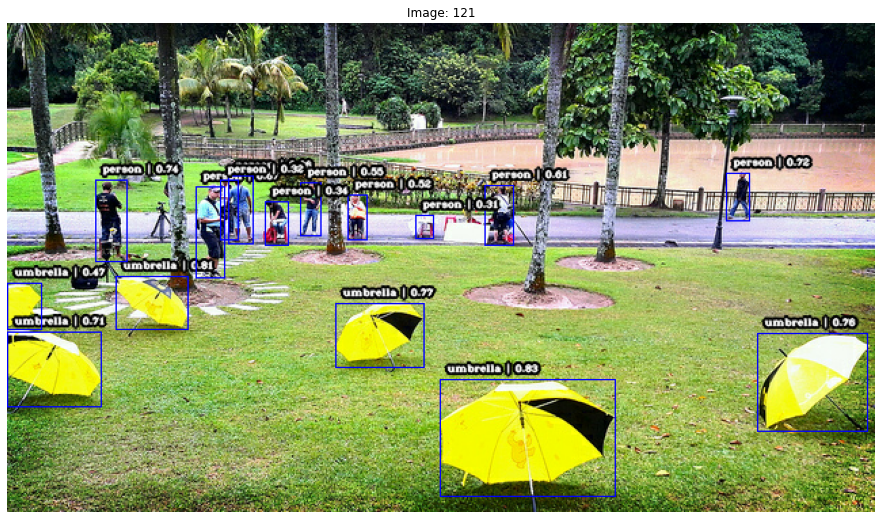

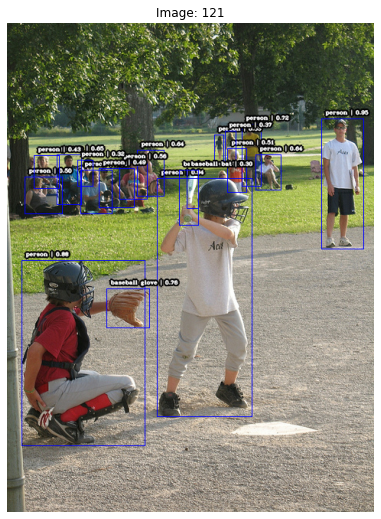

In [9]:
indices = [4348, 121]

inputs = []
scales = []
for idx in indices:
    image = read_image(image_paths[idx])
    image_height, image_width, _ = image.get_shape().as_list()
    scales.append(np.maximum(image_height, image_width))
    inputs.append(image)
    
with strategy.scope():
    distributed_inputs = distribute_input(inputs)
    tik = time()
    detections = distributed_inference(distributed_inputs)
    toc = time()

    
for i, (image, scale) in enumerate(zip(inputs, scales)):
    valid_detections = detections['valid_detections'][i].numpy()
    boxes = detections['boxes'][i][:valid_detections].numpy()

    # rescale box coordinates to original image space
    boxes = boxes * scale

    classes = [
        label_map[str(int(idx))]
        for idx in detections['classes'][i][:valid_detections].numpy()
    ]
    scores = detections['scores'][i][:valid_detections].numpy()

    #  Visualize detections
    imshow(
        visualize_detections_cv2(
            image,
            boxes,
            classes,
            scores,
            score_threshold=0.30,
            save=False,
            filename='image_{}.png'.format(idx)),
        title='Image: {}'.format(idx))
    
# First run will be slower, consequent runs will be significantly faster    
print('Inference time: {:.2f} ms'.format((toc - tik) * 1000))    